# Skane
# Kronoberg


![My Image](./Map-of-Sweden-showing-the-21-administrative-regions-adapted-from-SCB-2007.png)


In [1]:
#importing modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# 1. DATA preprocessing

In [2]:
#Parameters
n=20
starting_week = 10-4 #start week
first_case = 9
T_max = 48 #length of prediction
pv = 0.023 #fraction of infected that are admitted
rho = 7*1/5.1 #latency period
gamma = 7*1/5 #recovery rate
delay = 3 #2.5 #delay from infection to admission

In [3]:
file = pd.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx', sheet_name = "Inskrivna i slutenvård")
data = [['Sthlm',           8, 2389923, 'SE-AB',  6524],
        ['VGR',             9, 1725881,  'SE-O', 23800],
        ['Skåne',          10, 1387650,  'SE-M', 10968],
        ['Östergötland',   11,  467095,  'SE-E', 10559],
        ['Jönköping',      12,  364750,  'SE-F',  8190],
        ['Södermanland',   13,  299101,  'SE-D', 10437],
        ['Uppsala',        14,  387628,  'SE-C',  5427],
        ['Gävleborg',      15,  287660,  'SE-X',  8504],
        ['Västmanland',    16,  277074,  'SE-U',  6075],
        ['Örebro',         17,  305726,  'SE-T', 28029],
        ['Norrbotten',     18,  249768, 'SE-BD', 18118],
        ['Dalarna',        19,  287806,  'SE-W', 17519],
        ['Västernorrland', 20,  244855,  'SE-Y',  5118],
        ['Värmland',       21,  282840,  'SE-S', 54665],
        ['Halland',        22,  336132,  'SE-N', 97239],
        ['Kalmar',         23,  245992,  'SE-H', 11165],
        ['Kronoberg',      24,  202163,  'SE-G', 21549],
        ['Västerbotten',   25,  273061,  'SE-AC', 8424],
        ['Jämtland',       26,  130972,  'SE-Z',  2931],
        ['Blekinge',       27,  159349,  'SE-K', 48935],
        ['Gotland',        28,   60106,  'SE-I',  3135]] 
regions = pd.DataFrame(data, columns = ['region', 'index','population', 'regionkod', 'area']) 
regions['density'] = regions['population']/regions['area']
first_cases = first_case*np.ones(21).astype(int) #week number when first case was recorded
regions['first case'] = first_cases
starting_weeks = first_cases - 3

regions.drop(regions.index[[20]],inplace=True) #remove Gotland


In [4]:
def getData(name, first_case):
    temp = regions.loc[regions['region'] == name] #find the right row
    index = temp['index'].values #find the region index
    N = temp['population'].values[0] #find population size of region
    R = file.iloc[index[0]] 
    R = R.replace(' ', 0) #replace missing data with 0
    R = R.replace('X', 0) 
    R = R.replace('IU', 0) 
    
    ind = np.arange(3, len(R), 2) 
    I = R.iloc[ind].values #extract admissions
    I = I[:-2] #remove last (incomplete) data point
    padding = np.zeros(10 - first_case + 3) 
    I = np.insert(I, 0, padding) 
    veckor = np.arange(0, len(I), 1) #create array of week numbers
    
    return I,veckor,N


#Load Google mobility data
def loadMobility(name, starting_week):
    df = pd.read_csv('../data/2020_SE_Region_Mobility_Report.csv') 
    temp = regions.loc[regions['region'] == name] 
    code = temp['regionkod'].values 
    temp2 = df.loc[df['iso_3166_2_code'] == code[0]]
    transit = temp2['transit_stations_percent_change_from_baseline'].values 
    dagar = np.arange(46, 46 + len(transit))
    tv = np.ceil(dagar / 7)
    
    
    gveckor = np.unique(tv)
    k = 0
    Tr = np.zeros(int(max(gveckor) - min(gveckor))+1)

    for i in gveckor:
        ind=tv==i
        Tr[k]=np.mean(transit[ind])/100
        k=k+1
    for i in range(1,len(Tr)):
        if np.isnan(Tr[i]):
            Tr[i]=Tr[i-1]
    #print(Tr)
    init=0.2 #set base line travel
    Tr[0:2]=[init,init]
    #print(Tr)
    #print(gveckor)
    #print(gveckor-svecka)
    Trfkn = interp1d(gveckor-starting_week, Tr, kind = "linear", fill_value = "extrapolate")
    #print(Tr)
    return Trfkn

In [5]:
def loadMobility_list(name_list, starting_week):
    Trfkn_dict = dict()
    for i in name_list:
       Trfkn_dict[i] = loadMobility(i, starting_week) 
    return Trfkn_dict


def getData_list(name_list, first_case):
    getData_dict = dict()
    for i in name_list:
        I, veckor, N = getData(i, first_case)
        getData_dict[i] =  {'I': I, 'veckor': veckor, 'N': N}
    return getData_dict

# 2. Correlation Analysis

In [6]:
name_list = regions.region.tolist()
Trfkn_dict = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 

In [7]:
region_name = ['Sthlm']
df = pd.DataFrame(getData_dict[region_name[0]]['I'])/regions[regions.region == region_name[0]].density.values

for j in getData_dict.keys():
    if j == region_name[0]:
        continue
    region_name.append(j)
    df_temp = pd.DataFrame(getData_dict[j]['I'])
  
    df_temp = df_temp/regions[regions.region ==j].density.values
    df = pd.concat([df,df_temp], axis = 1)
 

In [8]:
df.columns = region_name
df.head()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.101002,0.124111,0.0,0.0,0.0,0.0,0.056002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.corr()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
Sthlm,1.000000,0.843206,0.707943,0.968330,0.911792,0.912002,0.906437,0.851443,0.919852,0.608364,0.916373,0.942713,0.767337,0.609362,0.797345,0.845498,0.634756,0.777421,0.834126,0.277613
VGR,0.843206,1.000000,0.887548,0.728929,0.583918,0.913086,0.903484,0.892073,0.902264,0.570380,0.880070,0.705631,0.886026,0.854733,0.793608,0.925145,0.855745,0.805349,0.664991,0.540573
Skåne,0.707943,0.887548,1.000000,0.621677,0.400992,0.826470,0.836551,0.770706,0.844795,0.357385,0.694584,0.537343,0.825453,0.701450,0.634010,0.837116,0.895035,0.708041,0.714445,0.703238
Östergötland,0.968330,0.728929,0.621677,1.000000,0.949446,0.843867,0.836592,0.758317,0.858380,0.558964,0.861616,0.937252,0.634197,0.456047,0.695051,0.749121,0.519094,0.666688,0.848179,0.214819
Jönköping,0.911792,0.583918,0.400992,0.949446,1.000000,0.742007,0.728714,0.634586,0.728252,0.546562,0.769218,0.934666,0.496379,0.328326,0.611534,0.626122,0.309441,0.592080,0.726492,0.029500
Södermanland,0.912002,0.913086,0.826470,0.843867,0.742007,1.000000,0.935397,0.890879,0.919812,0.666803,0.861836,0.819782,0.839591,0.734929,0.810330,0.888893,0.747598,0.818094,0.757545,0.496441
Uppsala,0.906437,0.903484,0.836551,0.836592,0.728714,0.935397,1.000000,0.834167,0.951433,0.563244,0.822067,0.805795,0.879517,0.724591,0.791194,0.910907,0.725122,0.833061,0.812731,0.496166
Gävleborg,0.851443,0.892073,0.770706,0.758317,0.634586,0.890879,0.834167,1.000000,0.888467,0.611241,0.894599,0.780226,0.822392,0.799760,0.880823,0.863245,0.827918,0.790691,0.698229,0.388709
Västmanland,0.919852,0.902264,0.844795,0.858380,0.728252,0.919812,0.951433,0.888467,1.000000,0.591124,0.874052,0.816632,0.876964,0.703475,0.832255,0.882670,0.768168,0.795805,0.850684,0.471452
Örebro,0.608364,0.570380,0.357385,0.558964,0.546562,0.666803,0.563244,0.611241,0.591124,1.000000,0.661141,0.610308,0.579358,0.611706,0.725711,0.523089,0.391109,0.514327,0.427815,0.262842


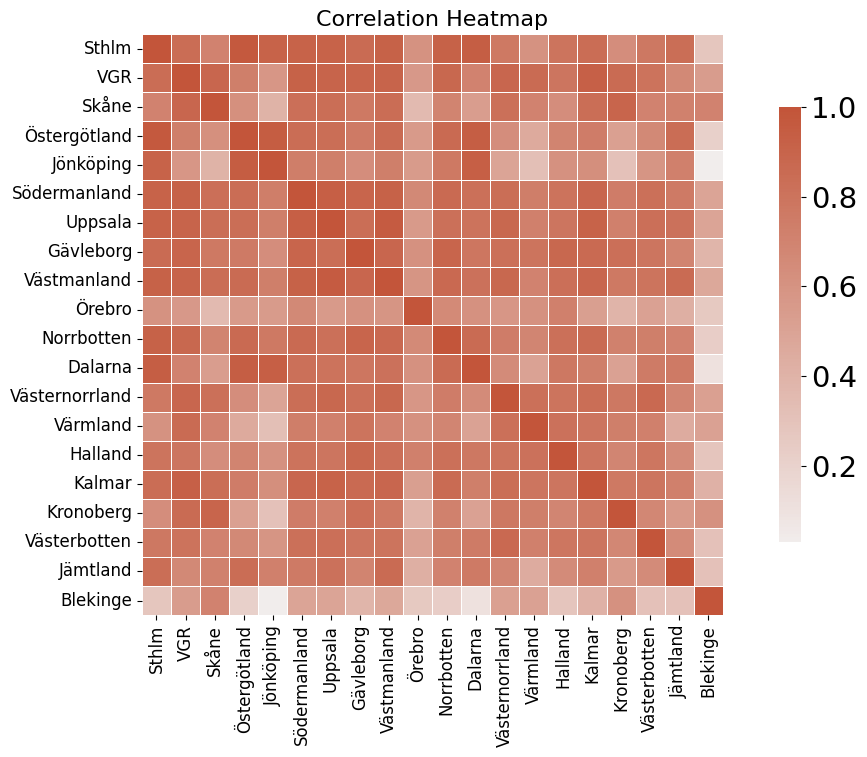

In [10]:
import seaborn as sns


corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(
    corr,
    cmap=cmap,
           # show correlation coefficients
    fmt=".2f",        # format for annotations
    linewidths=0.5,   # space between cells
    square=True,      # keep the cells square
    cbar_kws={"shrink": 0.75},  # color bar size
    center=0   ,
    annot_kws={"size": 8}       # center the colormap at zero
)

# Add title and tweak layout
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("../data/correlation_heatmap.svg", format="svg")

# Display the plot
plt.show()

In [11]:
df_Sthlm = pd.DataFrame(df.corr().loc['Sthlm']).sort_values(by = 'Sthlm', ascending=False)
df_Sthlm

,Sthlm
Sthlm,1.000000
Östergötland,0.968330
Dalarna,0.942713
Västmanland,0.919852
Norrbotten,0.916373
Södermanland,0.912002
Jönköping,0.911792
Uppsala,0.906437
Gävleborg,0.851443
Kalmar,0.845498


In [12]:
df_Skåne= pd.DataFrame(df.corr().loc['Skåne']).sort_values(by = 'Skåne', ascending=False)
df_Skåne

,Skåne
Skåne,1.000000
Kronoberg,0.895035
VGR,0.887548
Västmanland,0.844795
Kalmar,0.837116
Uppsala,0.836551
Södermanland,0.826470
Västernorrland,0.825453
Gävleborg,0.770706
Jämtland,0.714445


In [13]:
df_Uppsala= pd.DataFrame(df.corr().loc['Uppsala']).sort_values(by = 'Uppsala', ascending=False)
df_Uppsala

,Uppsala
Uppsala,1.000000
Västmanland,0.951433
Södermanland,0.935397
Kalmar,0.910907
Sthlm,0.906437
VGR,0.903484
Västernorrland,0.879517
Östergötland,0.836592
Skåne,0.836551
Gävleborg,0.834167


# 3. Modeling

#### S[Sthlm]=x0      

#### E[Sthlm]=x1       

#### I[Sthlm]=x2       

#### R[Sthlm]=x3

#### S[Södermanland]=x4      

#### E[Södermanland]=x5       

#### I[Södermanland]=x6       

#### R[Södermanland]=x7

In [14]:
name_list = ['Skåne', 'Kronoberg']
transit_fkn_dct = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 
region_0 = name_list[0]
region_1 = name_list[1]
I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[region_0]['veckor'] 

def beta(t, a, b, transit_fkn):
    return a + b * transit_fkn(t)

def dx(x, t, N, a, b, c, lag):
    S0, E0, I0, R0, S1, E1, I1, R1 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]

    dS0 =  - S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1])
    dS1 =  - S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0])
    dE0 =    S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1]) - rho*E0
    dE1 =    S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0]) - rho*E1
    dI0 =  rho*E0 - gamma*I0
    dI1 =  rho*E1 - gamma*I1
    dR0 =  gamma*I0
    dR1 =  gamma*I1

    return [dS0, dE0, dI0, dR0,
            dS1, dE1, dI1, dR1]

def pred_inlagda(t, a1, b1, a2, b2, c, lag):
    N = [getData_dict[name_list[0]]['N'],
         getData_dict[name_list[1]]['N']]
    x0 = [N[0]-1, 0, 1, 0,
          N[1]-1, 0, 1, 0] #initial conditions
    x = odeint(dx, x0, t, args=(N, [a1, a2], [b1, b2], c, lag))
    return pv*x[:, [2, 6]]

In [15]:
getData_dict

{'Skåne': {'I': array([0.0, 0.0, 0.0, 0.0, 0, 0, 25, 44, 82, 97, 105, 107, 100, 94, 89,
         95, 86, 74, 79, 71, 55, 39, 37, 19, 33, 19, 16, 41, 25, 25, 19, 24,
         25, 23, 17, 32, 30, 47, 84, 120, 168, 156, 189, 205, 242],
        dtype=object),
  'veckor': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  'N': 1387650},
 'Kronoberg': {'I': array([0.0, 0.0, 0.0, 0.0, 0, 0, 0, 7, 0, 16, 22, 17, 28, 21, 18, 23, 22,
         15, 9, 13, 4, 5, 0, 0, 0, 8, 0, 4, 0, 0, 0, 0, 6, 7, 0, 10, 15, 12,
         23, 17, 29, 33, 31, 27, 37], dtype=object),
  'veckor': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  'N': 202163}}

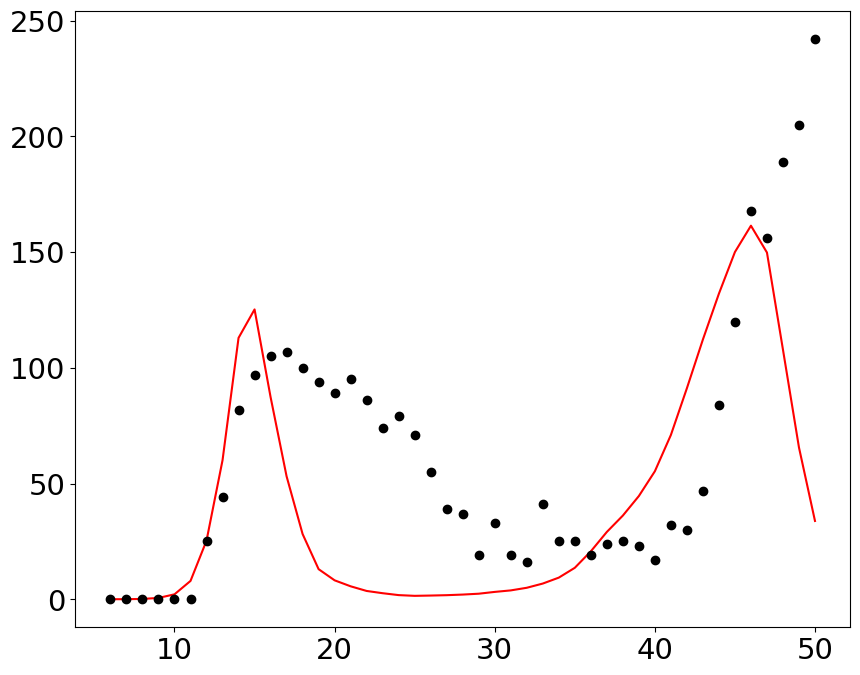

In [16]:
a = [3.662573, 2.997906 ] 
b = [8.139158,  6.992810]   
c = 0
P = pred_inlagda(weeks_train, a[0], b[0], a[1], b[1], c, delay)
fig, axes = plt.subplots(1, 1, figsize = (10, 8))
axes.plot(weeks_train+6, P[:,0], 'r', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[0], 'ko', label = "Inlagda")


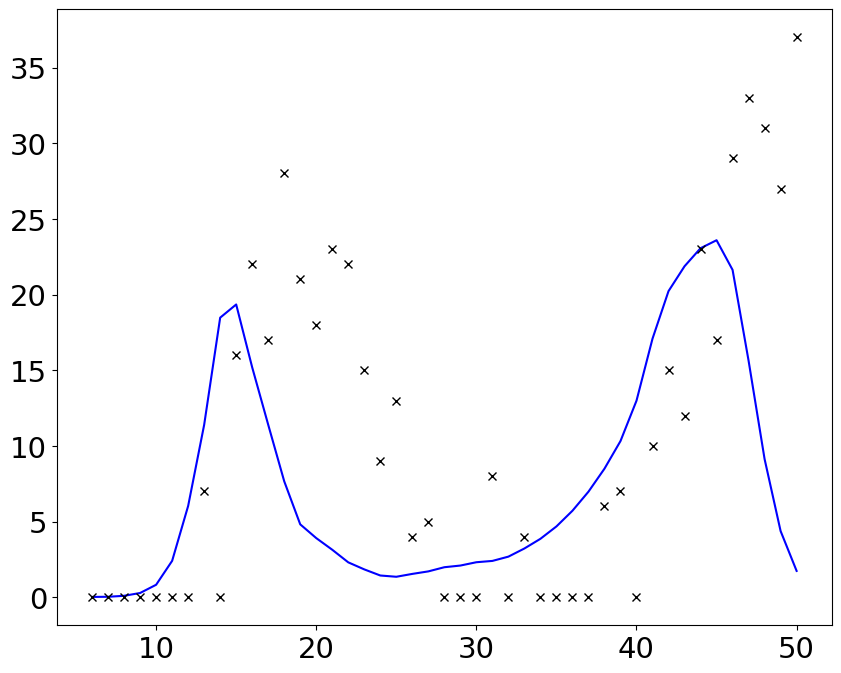

In [17]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))

axes.plot(weeks_train+6, P[:,1], 'b', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[1], 'kx', label = "Inlagda")

In [18]:
def return_RMSE(P, I):
    return np.sqrt(np.mean((P - I)**2))

def return_CV_RMSE(P, I):
    return 100 * return_RMSE(P, I) / np.mean(I)

In [19]:
print(return_RMSE(P[:,0], I_train[0]))
print(return_RMSE(P[:,1], I_train[1]))
print(return_CV_RMSE(P[:,0], I_train[0]))
print(return_CV_RMSE(P[:,1], I_train[1]))

57.15372023117821
11.250860350653582
90.62429212131852
105.69701790801903


In [20]:
#!pip install wandb


In [21]:
from tqdm import tqdm

name_list = ['Skåne', 'Kronoberg']
transit_fkn_dict = loadMobility_list(name_list, starting_week) 
getData_dict = getData_list(name_list, first_case)

I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[name_list[0]]['veckor']  # getData_dict['Södermanland']['veckor'] == getData_dict['Sthlm']['veckor']

n=3
ah0 = np.linspace(3,10,n)
bh0 = np.linspace(4,10,n)
ah1 = np.linspace(3,10,n)
bh1 = np.linspace(4,10,n)
c = np.linspace(0,0.2,n)

E_rmse0 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))
E_rmse1 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))

E_cv_rmse0 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))
E_cv_rmse1 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))

for i in tqdm(range(n)):
    for j in range(n):
        for k in range(n):
            for l in range(n): 
                for m in range(n):
                    P = pred_inlagda(weeks_train, ah0[i], bh0[j], ah1[k], bh1[l], c[m], delay)
                    
                    # Store the results in the arrays (instead of RMSE)
                    E_rmse0[i,j,k,l,m] = return_RMSE(P[:,0], I_train[0])
                    E_rmse1[i,j,k,l,m] = return_RMSE(P[:,1], I_train[1])  

                    # Store the results in the arrays (instead of cv-rms)
                    E_cv_rmse0[i, j, k, l, m] = return_CV_RMSE(P[:,0], I_train[0]) 
                    E_cv_rmse1[i, j, k, l, m] = return_CV_RMSE(P[:,1], I_train[1])

                                

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.57s/it]


In [22]:
sweep_config = {
    'method': 'random'
    }

In [23]:
metric = {
    'name': 'CV_RMSE',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [24]:
parameters_dict = {
    "ah0": {
        "min": 0,
        "max": 6,
        "distribution": "uniform"
    },
    "bh0": {
        "min": 3,
        "max": 15,
        "distribution": "uniform"
    },
    "ah1": {
        "min": 0,
        "max": 10,
        "distribution": "uniform"
    },
    "bh1": {
        "min": 3,
        "max": 15,
        "distribution": "uniform"
    },
    "c": {
        "min": 0,
        "max": 5,
        "distribution": "uniform"
    }
}

sweep_config['parameters'] = parameters_dict


In [25]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'CV_RMSE'},
 'parameters': {'ah0': {'distribution': 'uniform', 'max': 6, 'min': 0},
                'ah1': {'distribution': 'uniform', 'max': 10, 'min': 0},
                'bh0': {'distribution': 'uniform', 'max': 15, 'min': 3},
                'bh1': {'distribution': 'uniform', 'max': 15, 'min': 3},
                'c': {'distribution': 'uniform', 'max': 5, 'min': 0}}}


In [26]:
import wandb


In [27]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-SEIR_Skåne_Kronoberg")

Create sweep with ID: uenjiggc
Sweep URL: https://wandb.ai/danish2562022/sweeps-SEIR_Sk%C3%A5ne_Kronoberg/sweeps/uenjiggc


In [28]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms


def fit_model(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        P = pred_inlagda(weeks_train, config.ah0, config.bh0, config.ah1, config.bh1, config.c, delay)
        CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
        CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
        CV_RMSE = CV_RMSE_1 + CV_RMSE_2
        RMSE_1 = return_RMSE(P[:,0], I_train[0])
        RMSE_2 = return_RMSE(P[:,1], I_train[1])
        RMSE = RMSE_1 + RMSE_2
        wandb.log({"CV_RMSE": CV_RMSE, "RMSE": RMSE,  "RMSE_skane": RMSE_1,  "RMSE_kronoberg": RMSE_2,  "CV_RMSE_'skane": CV_RMSE_1,  "CV_RMSE_kronoberg": CV_RMSE_2})  

In [ ]:
wandb.agent(sweep_id,fit_model, count=10000)

wandb: Agent Starting Run: n42rq0v4 with config:
wandb: 	ah0: 4.380529433363135
wandb: 	ah1: 7.892337156172376
wandb: 	bh0: 14.113974643146184
wandb: 	bh1: 7.409797224227816
wandb: 	c: 2.2178589590622613
wandb: Currently logged in as: danish2562022. Use `wandb login --relogin` to force relogin


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4984.70763
CV_RMSE_'skane,2637.9083
CV_RMSE_kronoberg,2346.79933
RMSE,1913.44459
RMSE_kronoberg,249.80375


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0swnah9c with config:
wandb: 	ah0: 0.6755349489535187
wandb: 	ah1: 9.077501689083531
wandb: 	bh0: 7.471812352531748
wandb: 	bh1: 14.30556446073654
wandb: 	c: 2.594198742175742


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4792.94325
CV_RMSE_'skane,2369.63489
CV_RMSE_kronoberg,2423.30835
RMSE,1752.39745
RMSE_kronoberg,257.94771


wandb: Agent Starting Run: paxv3mry with config:
wandb: 	ah0: 3.205529060037726
wandb: 	ah1: 6.1567786719054975
wandb: 	bh0: 11.89507353131504
wandb: 	bh1: 13.64089590021791
wandb: 	c: 2.2875272162448046


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4813.88306
CV_RMSE_'skane,2513.94264
CV_RMSE_kronoberg,2299.94042
RMSE,1830.27571
RMSE_kronoberg,244.81588


wandb: Agent Starting Run: te9rhohl with config:
wandb: 	ah0: 2.949639473483776
wandb: 	ah1: 4.586806036291895
wandb: 	bh0: 12.40496584696166
wandb: 	bh1: 3.427784319094632
wandb: 	c: 4.1523193853748745


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4855.87721
CV_RMSE_'skane,2578.69977
CV_RMSE_kronoberg,2277.17744
RMSE,1868.69287
RMSE_kronoberg,242.39289


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pcw50zrg with config:
wandb: 	ah0: 2.976494344766005
wandb: 	ah1: 3.418627565585184
wandb: 	bh0: 5.002264567981964
wandb: 	bh1: 6.920209257487697
wandb: 	c: 2.9126351975079645


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4220.10005
CV_RMSE_'skane,2248.91464
CV_RMSE_kronoberg,1971.18541
RMSE,1628.13724
RMSE_kronoberg,209.82174


wandb: Agent Starting Run: iv6tvv0f with config:
wandb: 	ah0: 2.160846125930588
wandb: 	ah1: 2.5631999405187997
wandb: 	bh0: 4.498464619214436
wandb: 	bh1: 12.503740651604964
wandb: 	c: 1.5539274630837108


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1148.19277
CV_RMSE_'skane,701.10752
CV_RMSE_kronoberg,447.08526
RMSE,489.75488
RMSE_kronoberg,47.58974


wandb: Agent Starting Run: 0ornbwn9 with config:
wandb: 	ah0: 0.3193049341633707
wandb: 	ah1: 1.7380028533426872
wandb: 	bh0: 11.141881753296106
wandb: 	bh1: 9.472853195463568
wandb: 	c: 4.695288470091124


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4086.49264
CV_RMSE_'skane,2108.65636
CV_RMSE_kronoberg,1977.83628
RMSE,1540.38896
RMSE_kronoberg,210.52968


wandb: Agent Starting Run: wparpy0z with config:
wandb: 	ah0: 5.672153129212086
wandb: 	ah1: 6.98207766446559
wandb: 	bh0: 11.218424051935946
wandb: 	bh1: 14.949605897088457
wandb: 	c: 3.885827881538738


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,5239.40388
CV_RMSE_'skane,2803.22802
CV_RMSE_kronoberg,2436.17585
RMSE,2027.21986
RMSE_kronoberg,259.31739


wandb: Agent Starting Run: qtjylh4p with config:
wandb: 	ah0: 4.412316139023555
wandb: 	ah1: 7.155570639614735
wandb: 	bh0: 8.747087959170102
wandb: 	bh1: 3.4467143262193236
wandb: 	c: 0.7840724227777218


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4347.08408
CV_RMSE_'skane,2169.35657
CV_RMSE_kronoberg,2177.7275
RMSE,1599.94787
RMSE_kronoberg,231.80699


wandb: Agent Starting Run: g0perqoq with config:
wandb: 	ah0: 1.967135096128855
wandb: 	ah1: 9.014529639989512
wandb: 	bh0: 5.761984915686483
wandb: 	bh1: 8.894471718001506
wandb: 	c: 3.151770911677435


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4971.49223
CV_RMSE_'skane,2552.23971
CV_RMSE_kronoberg,2419.25251
RMSE,1867.1285
RMSE_kronoberg,257.51599


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kzj9s0zu with config:
wandb: 	ah0: 0.2706657606064844
wandb: 	ah1: 0.18701650254821067
wandb: 	bh0: 8.741428273402184
wandb: 	bh1: 3.5895489384684627
wandb: 	c: 1.9243382157573443


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,278.58485
CV_RMSE_'skane,134.91173
CV_RMSE_kronoberg,143.67312
RMSE,100.37753
RMSE_kronoberg,15.29321


wandb: Agent Starting Run: 6is6pqdm with config:
wandb: 	ah0: 3.7950557703959578
wandb: 	ah1: 3.28214219312248
wandb: 	bh0: 13.186486833063842
wandb: 	bh1: 10.609491236478965
wandb: 	c: 0.65963623199291


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1447.77697
CV_RMSE_'skane,800.35069
CV_RMSE_kronoberg,647.42628
RMSE,573.66943
RMSE_kronoberg,68.91493


wandb: Agent Starting Run: xl6f181o with config:
wandb: 	ah0: 1.145191413996307
wandb: 	ah1: 3.5853212546619395
wandb: 	bh0: 9.579016681446491
wandb: 	bh1: 11.05294680412161
wandb: 	c: 3.9526942289587934


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4480.63094
CV_RMSE_'skane,2326.57234
CV_RMSE_kronoberg,2154.05859
RMSE,1696.57919
RMSE_kronoberg,229.28757


wandb: Agent Starting Run: 9vgk62nb with config:
wandb: 	ah0: 5.435558922597258
wandb: 	ah1: 8.816596767727475
wandb: 	bh0: 3.986367061976176
wandb: 	bh1: 8.269847492206544
wandb: 	c: 0.9517297756027382


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4862.43787
CV_RMSE_'skane,2519.62934
CV_RMSE_kronoberg,2342.80853
RMSE,1838.42519
RMSE_kronoberg,249.37895


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wdqu3hnd with config:
wandb: 	ah0: 2.405463310874316
wandb: 	ah1: 7.385665477657852
wandb: 	bh0: 12.405784993767565
wandb: 	bh1: 14.474888687991402
wandb: 	c: 4.542659556729757


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,5185.87214
CV_RMSE_'skane,2751.36591
CV_RMSE_kronoberg,2434.50623
RMSE,1994.33443
RMSE_kronoberg,259.13966


wandb: Agent Starting Run: 15wsd4jq with config:
wandb: 	ah0: 2.3981538931402495
wandb: 	ah1: 1.3802395938292644
wandb: 	bh0: 14.875862937964726
wandb: 	bh1: 4.859215941250986
wandb: 	c: 0.28626322363891954


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,276.72574
CV_RMSE_'skane,133.63177
CV_RMSE_kronoberg,143.09397
RMSE,99.50866
RMSE_kronoberg,15.23156


wandb: Agent Starting Run: s8rnld06 with config:
wandb: 	ah0: 3.1108682030968753
wandb: 	ah1: 7.689046385893857
wandb: 	bh0: 7.640367945129277
wandb: 	bh1: 13.190555524865008
wandb: 	c: 3.269910716313576


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,5061.67038
CV_RMSE_'skane,2645.74593
CV_RMSE_kronoberg,2415.92445
RMSE,1925.7455
RMSE_kronoberg,257.16174


wandb: Agent Starting Run: 32w8860v with config:
wandb: 	ah0: 1.6282945283339276
wandb: 	ah1: 1.2734837178616654
wandb: 	bh0: 4.968825537897433
wandb: 	bh1: 13.305667622327617
wandb: 	c: 0.3894736664551979


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,278.30059
CV_RMSE_'skane,134.32616
CV_RMSE_kronoberg,143.97443
RMSE,100.04031
RMSE_kronoberg,15.32528


wandb: Agent Starting Run: npxfpq7b with config:
wandb: 	ah0: 2.645520541991209
wandb: 	ah1: 8.414128843342688
wandb: 	bh0: 7.979631662720978
wandb: 	bh1: 7.306380944062205
wandb: 	c: 3.7682040314146055


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,5069.36042
CV_RMSE_'skane,2654.01341
CV_RMSE_kronoberg,2415.34701
RMSE,1930.89806
RMSE_kronoberg,257.10027


wandb: Agent Starting Run: ht0mnlby with config:
wandb: 	ah0: 5.213415595156038
wandb: 	ah1: 1.7920706665770036
wandb: 	bh0: 10.6377514837481
wandb: 	bh1: 8.546556955224226
wandb: 	c: 4.94957488766171


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4981.1962
CV_RMSE_'skane,2706.93661
CV_RMSE_kronoberg,2274.25959
RMSE,1949.25699
RMSE_kronoberg,242.0823


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o1pqeh1b with config:
wandb: 	ah0: 2.1303020078118244
wandb: 	ah1: 9.563030272828668
wandb: 	bh0: 14.620913980348462
wandb: 	bh1: 9.088263880532132
wandb: 	c: 3.948387180683194


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,5168.24652
CV_RMSE_'skane,2739.67194
CV_RMSE_kronoberg,2428.57458
RMSE,1986.32804
RMSE_kronoberg,258.50827


In [38]:
import wandb
import numpy as np
import random

# Initialize wandb project
wandb.init(project="random-search-pred_inlagda", name="random_search_run", config={})

# Define ranges of hyperparameters for sampling
param_space = {
    "ah0": [0, 10],
    "bh0": [0, 10],
    "ah1": [0, 10],
    "bh1": [0, 10],
    "c":   [0, 10]
}

# Number of random trials
n_trials = 500

# Random search loop
for _ in range(n_trials):
    # Randomly sample one value for each hyperparameter
    params = {key: random.choice(values) for key, values in param_space.items()}
    
    # Run model
    P = pred_inlagda(weeks_train, params["ah0"], params["bh0"], params["ah1"], params["bh1"], params["c"], delay)
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    CV_RMSE = CV_RMSE_1 + CV_RMSE_2    

    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    CV_RMSE = CV_RMSE_1 + CV_RMSE_2  
    
    # Log to wandb
    wandb.log({
        **params,
        "CV_RMSE": CV_RMSE
        "RMSE": RMSE
    })

# Finish wandb run
wandb.finish()


RMSE,▁█▇█▄▃█▇▄▄▅█▇▃██▁▁▅▇▇▅▁▅█▁▅▇▅▁█▇▅▁██▁▇▁█
ah0,▁▁▁▁▁████▁▁█▁▁██████▁█████▁█▁█▁▁██▁█▁▁▁█
ah1,▁▁▁▁██▁██▁▁██▁▁█████▁█▁██████▁▁█████▁▁▁▁
bh0,▁█████▁▁██▁████▁▁▁▁▁█▁▁███▁▁▁▁█▁████▁▁▁█
bh1,▁▁▁█▁▁███▁▁▁█▁▁███▁▁██▁█▁▁█▁▁▁███▁▁▁▁█▁█
c,███▁█▁▁█▁▁▁███▁██▁█▁▁█▁▁██▁▁▁█▁█████████
RMSE,2405.68111
ah0,0
ah1,0
bh0,10
bh1,10


In [17]:
optind0 = np.where(E_rmse0 == np.amin(E_rmse0))
optind0_cv = np.where(E_cv_rmse0 == np.amin(E_cv_rmse0))
a0fitE0 = ah0[optind0[0]]
b0fitE0 = bh0[optind0[1]]
a1fitE0 = ah1[optind0[2]]
b1fitE0 = bh1[optind0[3]]
cfitE0  =   c[optind0[4]]
a0fitE0_cv = ah0[optind0_cv[0]]
b0fitE0_cv = bh0[optind0_cv[1]]
a1fitE0_cv = ah1[optind0_cv[2]]
b1fitE0_cv = bh1[optind0_cv[3]]
cfitE0_cv  =   c[optind0_cv[4]]
print(optind0)
print(optind0_cv)
print(a0fitE0, b0fitE0, a1fitE0, b1fitE0, cfitE0)
print(a0fitE0_cv, b0fitE0_cv, a1fitE0_cv, b1fitE0_cv, cfitE0_cv)
print("Minimum RMSE: ",E_rmse0[optind0])
print("Minimum CV-RMSE: ",E_cv_rmse0[optind0_cv])

(array([0]), array([1]), array([1]), array([0]), array([1]))
(array([0]), array([1]), array([1]), array([0]), array([1]))
[3.] [7.] [6.5] [4.] [0.1]
[3.] [7.] [6.5] [4.] [0.1]
Minimum RMSE:  [277.95568688]
Minimum CV-RMSE:  [98.99490233]


In [18]:
optind1 = np.where(E_rmse1 == np.amin(E_rmse1))
optind1_cv = np.where(E_cv_rmse1 == np.amin(E_cv_rmse1))
a0fitE1 = ah0[optind1[0]]
b0fitE1 = bh0[optind1[1]]
a1fitE1 = ah1[optind1[2]]
b1fitE1 = bh1[optind1[3]]
cfitE1  =   c[optind1[4]]
a0fitE1_cv = ah0[optind1_cv[0]]
b0fitE1_cv = bh0[optind1_cv[1]]
a1fitE1_cv = ah1[optind1_cv[2]]
b1fitE1_cv = bh1[optind1_cv[3]]
cfitE1_cv  =   c[optind1_cv[4]]
print(optind1)
print(optind1_cv)
print(a0fitE1, b0fitE1, a1fitE1, b1fitE1, cfitE1)
print(a0fitE1_cv, b0fitE1_cv, a1fitE1_cv, b1fitE1_cv, cfitE1_cv)
print("Minimum RMSE: ",E_rmse1[optind1])
print("Minimum CV-RMSE: ",E_cv_rmse1[optind1_cv])

(array([1]), array([0]), array([0]), array([1]), array([1]))
(array([1]), array([0]), array([0]), array([1]), array([1]))
[6.5] [4.] [3.] [7.] [0.1]
[6.5] [4.] [3.] [7.] [0.1]
Minimum RMSE:  [24.14298631]
Minimum CV-RMSE:  [88.68852113]


In [19]:
E_rmse = E_rmse0 + E_rmse1
E_cv_rmse = E_cv_rmse0 + E_cv_rmse1
optind = np.where(E_rmse == np.amin(E_rmse))
optind_cv = np.where(E_cv_rmse == np.amin(E_cv_rmse))
a0fitE = ah0[optind[0]]
b0fitE = bh0[optind[1]]
a1fitE = ah1[optind[2]]
b1fitE = bh1[optind[3]]
cfitE  =   c[optind[4]]
a0fitE_cv = ah0[optind_cv[0]]
b0fitE_cv = bh0[optind_cv[1]]
a1fitE_cv = ah1[optind_cv[2]]
b1fitE_cv = bh1[optind_cv[3]]
cfitE_cv  =   c[optind_cv[4]]
print(optind)
print(optind_cv)
print(a0fitE, b0fitE, a1fitE, b1fitE, cfitE)
print(a0fitE_cv, b0fitE_cv, a1fitE_cv, b1fitE_cv, cfitE_cv)
print("Minimum RMSE: ",E_rmse[optind])
print("Minimum CV-RMSE: ",E_cv_rmse[optind_cv])

(array([0]), array([0]), array([0]), array([2]), array([1]))
(array([0]), array([0]), array([0]), array([2]), array([1]))
[3.] [4.] [3.] [10.] [0.1]
[3.] [4.] [3.] [10.] [0.1]
Minimum RMSE:  [382.78615013]
Minimum CV-RMSE:  [236.28067995]


In [32]:
# Function to compute RMSE for a specific combination of hyperparameters
def compute_rmse(i, j, k, l, m, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay):
    P = pred_inlagda(weeks_train, ah0[i], bh0[j], ah1[k], bh1[l], c[m], delay)
    
    RMSE0 = return_RMSE(P[:,0], I_train[0])
    RMSE1 = return_RMSE(P[:,1], I_train[1])
                    
    # Store the results in the arrays (instead of RMSE)
    E_rmse0[i,j,k,l,m] = RMSE0
    E_rmse1[i,j,k,l,m] = RMSE1 

    # Calculate the Coefficient of Variation of RMSE (CV-RMSE)
    CV_RMSE0 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE1 = return_CV_RMSE(P[:,1], I_train[1])
                                        
    # Store the results in the arrays (instead of cv-rmse)
    E_cv_rmse0[i, j, k, l, m] = CV_RMSE0
    E_cv_rmse1[i, j, k, l, m] = CV_RMSE1
    return (i, j, k, l, m, RMSE0, RMSE1, CV_RMSE0, CV_RMSE1)
print(ah0)
print(E_cv_rmse0)
compute_rmse(0,0,0,0,0, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay) 
print(E_cv_rmse0)

[3.]
[[[[[0.]]]]]
[[[[[132.07105663]]]]]


In [33]:
from tqdm import tqdm
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed


namn_list = ['Sthlm', 'Södermanland']
transit_fkn_dct = loadMobility_list(namn_list, starting_week) 
getData_dict = getData_list(namn_list, first_case)

I_train = [getData_dict[namn_list[0]]['I'],
           getData_dict[namn_list[1]]['I']]
weeks_train = getData_dict[namn_list[0]]['veckor']

n = 1
ah0 = np.linspace(3, 10, n)
bh0 = np.linspace(4, 10, n)
ah1 = np.linspace(3, 10, n)
bh1 = np.linspace(4, 10, n)
c =   np.linspace(0, 0.2, n)


E_rmse0 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))
E_rmse1 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))

E_cv_rmse0 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))
E_cv_rmse1 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))



# Parallel processing function
def parallel_search(n, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay):
    # Store futures to track processing
    futures = []
    with ProcessPoolExecutor() as executor:
        # Loop through all combinations of i, j, k, l, m
        for i in tqdm(range(n)):
            for j in range(n):
                for k in range(n):
                    for l in range(n):
                        for m in range(n):
                            # Submit the task to the executor
                            futures.append(executor.submit(compute_rmse, i, j, k, l, m, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay))

        # Collect results from the completed futures
        for future in tqdm(as_completed(futures)):
            i, j, k, l, m, RMSE0, RMSE1, CV_RMSE0, CV_RMSE1 = future.result()
            E_rmse0[i, j, k, l, m] = RMSE0
            E_rmse1[i, j, k, l, m] = RMSE1
            E_cv_rmse0[i, j, k, l, m] = CV_RMSE0 
            E_cv_rmse1[i, j, k, l, m] = CV_RMSE1

if __name__ == "__main__":
    parallel_search(n, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.15it/s]
0it [00:00, ?it/s]Process SpawnProcess-19:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/concurrent/futures/process.py", line 251, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'compute_rmse' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [79]:
%run -i parallell_grid_search.py
print(E_cv_rmse)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 37.31it/s]
32it [00:01, 17.71it/s]


[[[[[[ 132.07105663  266.89954043]
     [ 132.07105519  145.07097686]]

    [[ 132.07105629  411.52357819]
     [ 132.07105518  455.23390166]]]


   [[[ 141.46444834  140.26920471]
     [ 141.46444834  135.79792599]]

    [[ 141.46444839  346.38533447]
     [ 141.46444839  421.31853227]]]]



  [[[[ 985.51989585  991.11978118]
     [ 985.51989369  992.18490846]]

    [[ 985.51989504 1012.33768634]
     [ 985.51989007 1016.40540828]]]


   [[[1019.21401546 1020.8075171 ]
     [1019.21401522 1021.03856189]]

    [[1019.2140211  1027.49564889]
     [1019.21402096 1031.33656187]]]]]




 [[[[[ 449.8093266   451.33122435]
     [ 121.48130424  135.77557414]]

    [[1333.1332519  1333.46565732]
     [1377.95386763 1378.21970564]]]


   [[[ 449.80932262  421.8469298 ]
     [ 121.48130432  120.18099843]]

    [[1333.13325123 1333.536733  ]
     [1377.95386741 1378.2700245 ]]]]



  [[[[ 449.80933868  516.49824952]
     [ 121.48130519  358.95960396]]

    [[1333.13325437 1335.56254057]
     [137

In [371]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]

print("Minimum RMSE: ",E_sthlm[optind])
#print("a=",afiE_sthlm,"b=",bfit)

Minimum RMSE:  [577.20146072]


In [ ]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]


In [76]:
regs = pandas.read_pickle('../data/param_IC.pkl') #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

In [66]:
range(2)

range(0, 2)

In [67]:
i in range(2)

False

In [69]:
for i in range(2):
    print(i)

0
1
